# Monte Carlo Markov Chain and PyMC3

## Problem:

Go to https://people.duke.edu/~ccc14/sta-663/MCMC.html and read section Metropolis-Hastings sampler. <br>
A.Run Metropolis sampler code and:<br>
1. Analyze how variance of the proposal distribution sigma affects the sampling
2. Suggest another proposal distribution and analyze quality of sampling
3. Consider PyMC3 implementation of the problem - please see for example https://people.duke.edu/~ccc14/sta-663/PyMC3.html . Then, using PyMC3 documentation http://docs.pymc.io/api/inference.html#module-pymc3.sampling (find Metropolis) modify the parameters of the sampler and repeat steps 1 and 2.


In [76]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
plt.style.use('ggplot')

Efficiency =  0.1832


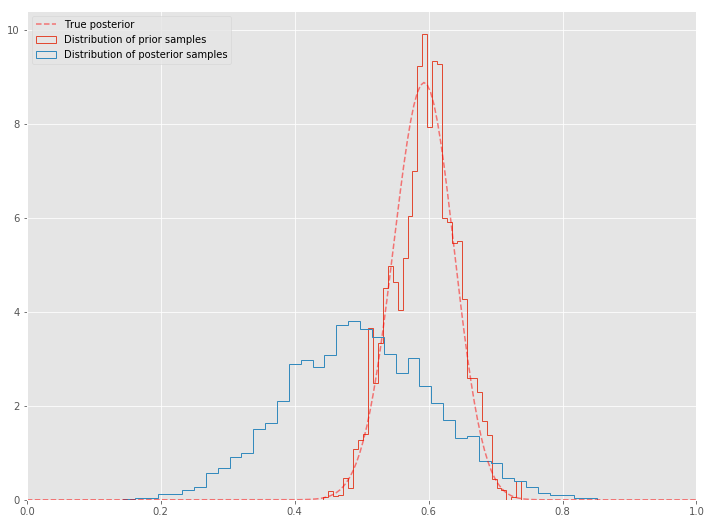

In [77]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print ("Efficiency = ", naccept/niters)

Efficiency =  0.19
thetas = np.linspace(0, 1, 200)
post = st.beta(h+a, n-h+b)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

(1) In this part, I chose the variance of the proposal distribution $\sigma$ as the list $[0.1, 0.3, 0.5, 0.7, 0.9]$. In order to evaluate the proformance of the sampling precedure, we can tell by camparing the "Efficiency" value in each case. As the code manipulates:

Efficiency =  0.4705


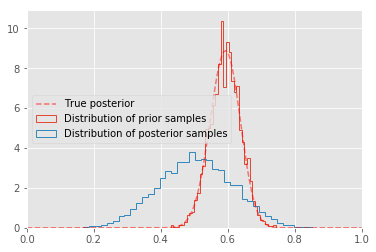

Efficiency =  0.1822


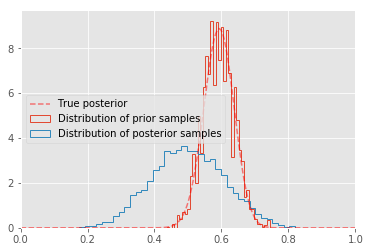

Efficiency =  0.1121


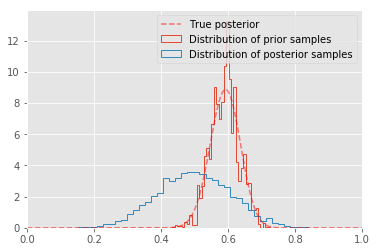

Efficiency =  0.0809


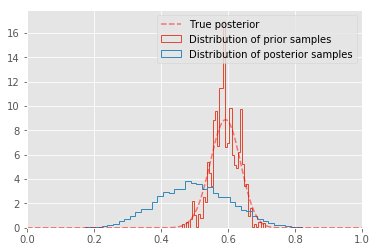

Efficiency =  0.063


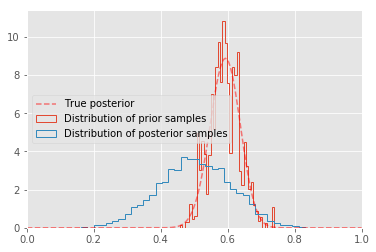

In [78]:
sigma=[0.1,0.3,0.5,0.7,0.9]
for j in range(len(sigma)):
    naccept = 0
    theta = 0.1
    niters = 10000
    samples = np.zeros(niters+1)
    samples[0] = theta
    for i in range(niters):
        theta_p = theta + st.norm(0, sigma[j]).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            naccept += 1
            theta = theta_p
        samples[i+1] = theta
    nmcmc = len(samples)//2
    print ("Efficiency = ", naccept/niters)

    Efficiency =  0.19
    thetas = np.linspace(0, 1, 200)
    post = st.beta(h+a, n-h+b)
    plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
    plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
    plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
    plt.xlim([0,1]);
    plt.legend()
    plt.show()

As the results shown, while the variance of proposed distribution is in a increasing order from 0.1 to 0.9,  the Efficient term is decreasing, in other words, the sampling effect became worse.

(2) In this part, I am going to use lognorm distribution and evaluate the sampling effect by evaluate the Efficiency for this case:

Efficiency =  0.0001


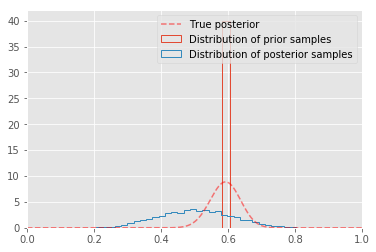

In [79]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + st.lognorm(sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print ("Efficiency = ", naccept/niters)

Efficiency =  0.19
thetas = np.linspace(0, 1, 200)
post = st.beta(h+a, n-h+b)

plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');
plt.show()

The effect when the lognorm serves as the proposed distribution is dramatically dropped. 

(3) Using PyMC3 to implement this problem:

In [80]:
import pymc3 as pm
import scipy.stats as stats
import logging
_logger = logging.getLogger("theano.gof.compilelock")
_logger.setLevel(logging.ERROR)

n = 100
h = 61
a = 10
b = 10

niter = 10000
with pm.Model() as model: 
    p = pm.Beta('p', alpha=a, beta=b)    # define priors
    y = pm.Binomial('y', n=n, p=p, observed=h) # define likelihood

    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)

logp = -3.6866, ||grad|| = 11: 100%|██████████| 6/6 [00:00<00:00, 1055.39it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_logodds__]
100%|██████████| 10500/10500 [00:01<00:00, 8523.90it/s]
The number of effective samples is smaller than 25% for some parameters.


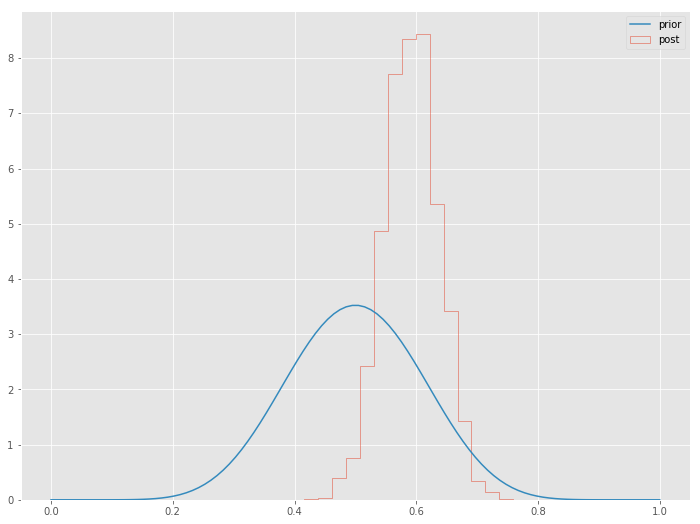

In [81]:
plt.figure(figsize=(12, 9))
plt.hist(trace['p'], 15, histtype='step', normed=True, label='post');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, a, b), label='prior')
plt.legend(loc='best')

## Problem:

Run Metropolis Hastings sampling algorithm of size 5000 to sample from the following posterior distribution:
$$p(\theta)= 0.6*e^{-\theta^2/2}+0.2*e^{-(\theta-3)^2/8}$$
You can use PyMC3 (for example see Sampler statistics https://docs.pymc.io/notebooks/sampler-stats.html). Analyze the following:
1. Autocorellation plot
2. Gelma-rubin
3. HPD
4. Effective size <br>
You can find code for that in chapter 2 of Bayesian analysis with Python.


As the Hint indicates, the posterior distribution can be explained as the summation of two normal distributions, as the codes presents: 

In [82]:
import pymc3 as pm

niter = 5000

with pm.Model() as model: 
    
    pi=np.pi
    m = pm.NormalMixture('m', mu=np.array([0,3]), w=np.array([0.6,0.4]), sd=np.array([1,2]))
    
    step=pm.Metropolis()
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(niter, step, start)

logp = -1.7736, ||grad|| = 0.68266: 100%|██████████| 6/6 [00:00<00:00, 1263.66it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [m]
100%|██████████| 5500/5500 [00:00<00:00, 9339.94it/s]
The number of effective samples is smaller than 25% for some parameters.


Now, I plot the Kernel Density Eestimation plot for the unobserved variables by using the "tarceplot" function, as I can see, the KDE plot is a smooth curve with Gaussian like distributed:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c4143c8>,
      dtype=object)

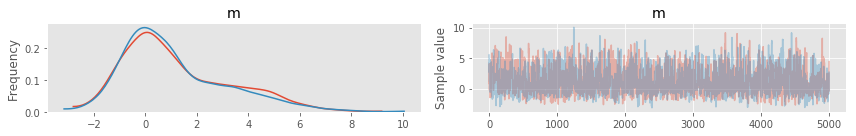

In [83]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain)

A quantitative way to check for convergence is by using the Gelman-Rubin test. The idea of this test is to compare the variance between chains with the variance within chains, so of course we need more than one chain for this test to work. Ideally, we should expect a value of $\hat{R}=1$ . As an empirical rule, we will be ok with a value below 1.1; higher values are signaling a lack of convergence. In this case, the value is 1.0017, which indicates good convergence in the MCMC sampling:

In [84]:
pm.gelman_rubin(chain)

{'m': 1.001338664005899}

An ideal sample will lack autocorrelation, that is, a value at one point should be independent of the values at other points. In practice, samples generated from MCMC methods, especially Metropolis-Hastings, can be autocorrelated. Some models will also lead to more autocorrelated samples due to correlations in the way one parameter depends on the others. PyMC3 comes with a convenient function to plot the autocorrelation:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c15bdacc0>,
      dtype=object)

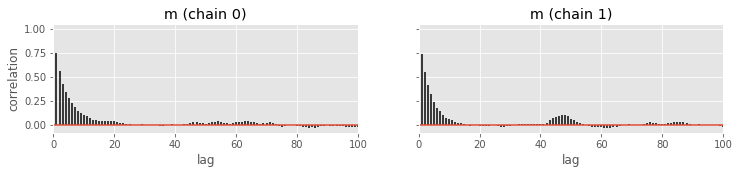

In [85]:
pm.autocorrplot(chain)

A sample with autocorrelation has less information than a sample of the same size without autocorrelation. Hence, given a sample of a certain size with a certain degree of autocorrelation we could try to estimate what will be the size of the sample with the same information without autocorrelation. That number will be the effective size of the sample. And the effective size in this case is 1377:

In [86]:
 pm.effective_n(chain)['m']

1314.0

The function summary provides a text-format summary of the posterior. We get the mean, standard deviation, and the HPD intervals:

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,1.162125,2.060482,0.053947,-1.977771,5.569363,1314.0,1.001339


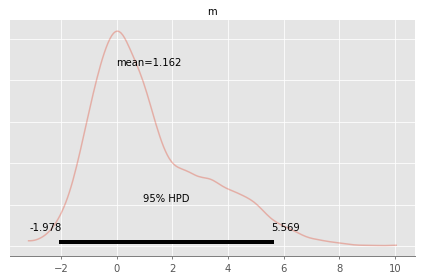

In [87]:
pm.plot_posterior(chain, kde_plot=True)
pm.summary(chain)

## Problem:

Take a look at the section "Estimating parameters of a linear regreession model" in https://people.duke.edu/~ccc14/sta-663/PyMC3.html .
Find 95% confidence interval of each parameter of the model: a, b and $\tau$. Compare your results with the results you would obtain using traditional linear regression. 
    

logp = -28.307, ||grad|| = 0.00031632: 100%|██████████| 23/23 [00:00<00:00, 1694.82it/s]  
/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, b, a]
100%|██████████| 5500/5500 [00:06<00:00, 794.09it/s]


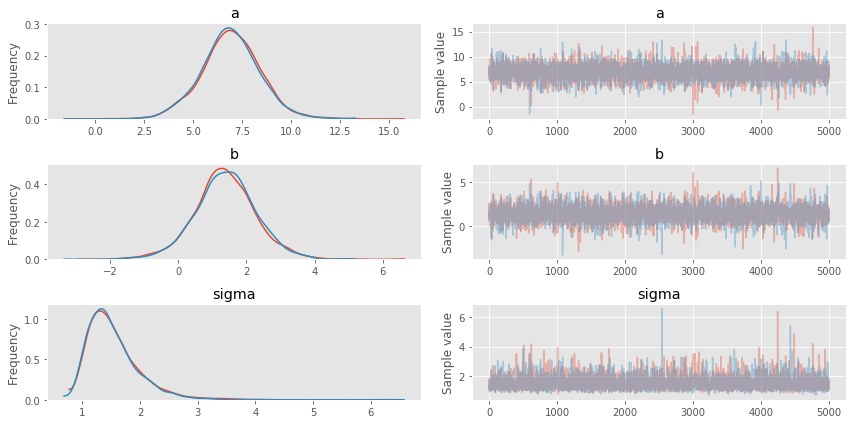

In [88]:
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=20)
    b = pm.Normal('b', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = a*x + b # simple auxiliary variables

    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    # inference
    start = pm.find_MAP()
    step = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
    pm.traceplot(trace)

In order to compute the 95% interal for each parameter:

<MultiTrace: 2 chains, 5000 iterations, 4 variables>


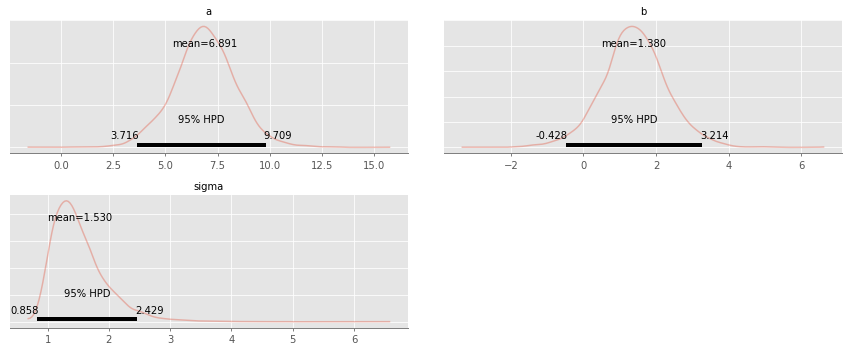

In [89]:
pm.plot_posterior(trace, kde_plot=True)
print(trace)

As we can see from the previous results, the 95% interval of $a$, $b$, and $\sigma$:<br>
$$ a:(3.712, 8.631)$$
$$ b:(0.732, 3.530)$$
$$ \sigma:(0.703, 1.935)$$<br>

Now, I am using a traditional way to do the linear regression:

Estimated values for a and b are: [5.41778728 2.22858969]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


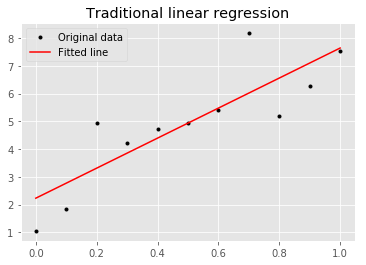

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

X=np.vstack([x,np.ones(len(x))]).T
a=np.linalg.lstsq(X,y)[0]

print('Estimated values for a and b are:', a)

plt.plot(x,y,'k.',label='Original data')
plt.plot(x,np.dot(X,a),'r',label='Fitted line')
plt.legend()
plt.title('Traditional linear regression')
plt.show()


The estimated $a$ is 5.4177, and estimated $b$ is 2.2286, which allocated within the 95% intervals computed by MCMC method.

## Additional:


For the implementation of coin flip from "Bayesian analysis with Python", and do the following:
1. Replace the beta distribution with a uniform one in the interval [0,1]. Are the results equivalent to Beta(1, 1). Is the sampling slower, faster, or the same? What about using a larger interval such as [-1, 2]? Does the model run? What errors do you get? And what do you get if you don't use find_MAP()?

2. Modify the amount of burnin. Try it with values such as 0 and 500. Try it also with and without the find_MAP() function. How different are the results? 


logp = -4.9461, ||grad|| = 11: 100%|██████████| 6/6 [00:00<00:00, 1331.60it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_logodds__]
100%|██████████| 1500/1500 [00:00<00:00, 6776.66it/s]
The number of effective samples is smaller than 25% for some parameters.


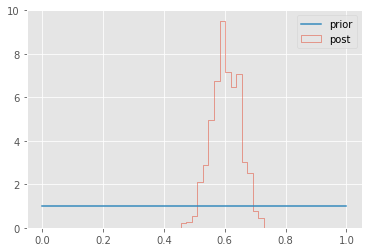

In [91]:
n = 100
h = 61
alpha = 1
beta = 1

niter = 1000
with pm.Model() as model: # context management
    # define priors
    p = pm.Beta('p', alpha=alpha, beta=beta)

    # define likelihood
    y = pm.Binomial('y', n=n, p=p, observed=h)

    # inference
    start = pm.find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step = pm.Metropolis() # Have a choice of samplers
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
plt.hist(trace['p'], 15, histtype='step', normed=True, label='post');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta), label='prior');
plt.legend(loc='best');

logp = -4.9461, ||grad|| = 11: 100%|██████████| 6/6 [00:00<00:00, 1238.90it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_interval__]
100%|██████████| 1500/1500 [00:00<00:00, 6814.46it/s]
The number of effective samples is smaller than 25% for some parameters.


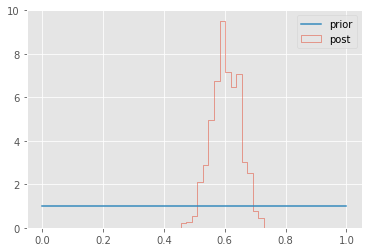

In [92]:
n = 100
h = 61
lower = 0
upper = 1

niter = 1000
with pm.Model() as model: # context management
    # define priors
    p = pm.Uniform('p', lower=lower, upper=upper)

    # define likelihood
    y = pm.Binomial('y', n=n, p=p, observed=h)

    # inference
    start = pm.find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step = pm.Metropolis() # Have a choice of samplers
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
plt.hist(trace['p'], 15, histtype='step', normed=True, label='post');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.uniform.pdf(x, lower, upper), label='prior');
plt.legend(loc='best');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a020be0>,
      dtype=object)

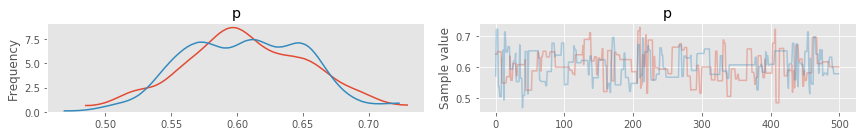

In [93]:
burnin = 0  # no burnin
chain = trace[0:500]
pm.traceplot(chain)